In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u 
from math import radians, degrees, sin, cos, asin, acos, sqrt
from opencage.geocoder import OpenCageGeocode
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import requests
from geopy.distance import great_circle
import pickle

plt.style.use("../harsh")

In [22]:
def gc(lon1, lat1, lon2, lat2):
    return great_circle((lat1, lon1), (lat2, lon2)).kilometers

vc_great_circle = np.vectorize(gc)

In [3]:
def carbon_simple_air_travel(travel_distance, travel_class="econ"):
    """
    simple calculator based on https://pics.uvic.ca/sites/default/files/AirTravelWP_FINAL.pdf. 
    takes in travel_distance [km, float] and travel_class [string]
    returns carbon emissions in [kg]
    """
    scaled_distance = 1.08*travel_distance #account for rerouting, holds, etc.
    
    if(scaled_distance < 463):
        return 0.27867*scaled_distance
    
    elif(scaled_distance < 3700):
        if(travel_class == "econ"):
            return 0.16508*scaled_distance
        else: 
            return 0.24761*scaled_distance 
    
    else:
        if(travel_class == "econ"):
            return 0.14678*scaled_distance
        elif(travel_class == "econ_plus"):
            return 0.23484*scaled_distance
        else: 
            return 0.42565*scaled_distance

In [4]:
def return_latlon(place):
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s'%(place, gmaps_api_key))
    resp_json_payload = response.json()
    results = resp_json_payload['results']
    if(len(results) == 0):
        return None
    else:
        lat = results[0]['geometry']['location']['lat']
        lng = results[0]['geometry']['location']['lng']
        return lat, lng

In [5]:
df = pd.read_csv("iau.csv")
df = df.fillna(" ")
inst = np.array(df['Institute'].values, dtype='str')
country = np.array(df['Country'].values, dtype='str')

In [6]:
unique_insts, idxs, counts = np.unique(inst, return_counts=True, return_index=True)

In [7]:
gmaps_api_key = "YOUR_API_KEY"
"""
fails = 0 
all_inst_latlons = np.zeros((len(unique_insts), 2))
for i in tqdm(range(len(unique_insts))):
    try:
        all_inst_latlons[i,0], all_inst_latlons[i,1] = return_latlon(unique_insts[i])
    except:
        print("%s DOESN'T EXIST" % unique_insts[i])
        fails += 1
        all_inst_latlons[i,0], all_inst_latlons[i,1] = np.nan, np.nan
"""


'\nfails = 0 \nall_inst_latlons = np.zeros((len(unique_insts), 2))\nfor i in tqdm(range(len(unique_insts))):\n    try:\n        all_inst_latlons[i,0], all_inst_latlons[i,1] = return_latlon(unique_insts[i])\n    except:\n        print("%s DOESN\'T EXIST" % unique_insts[i])\n        fails += 1\n        all_inst_latlons[i,0], all_inst_latlons[i,1] = np.nan, np.nan\n'

In [11]:
#inst_dict = dict(zip(unique_insts, all_inst_latlons))
inst_dict = pickle.load(open("institute_latlon.pkl", "rb"))

In [12]:
all_attendee_latlons = np.zeros((len(inst), 2))
flag_nan = np.zeros((len(inst)))
for i in tqdm(range(len(inst))):
    all_attendee_latlons[i] = inst_dict[inst[i]]
    if(np.isnan(inst_dict[inst[i]][0])):
        flag_nan[i] = 1

In [13]:
nan_flag = flag_nan == 0
final_insts = inst[nan_flag]
final_countries = country[nan_flag]
final_latlons = all_attendee_latlons[nan_flag]

In [14]:
def choose_attendees(number_attendees, proportion_north_american=0.9):
    p = np.zeros(len(final_countries))
    number_north_america = len(final_countries[(final_countries == "United States") | (final_countries == "Canada") | (final_countries == "Mexico")])
    number_world = len(final_countries) - number_north_america
    for i in range(len(final_countries)):
        if(final_countries[i] == "United States" or final_countries[i] == "Canada" or final_countries[i] == "Mexico"):
            p[i] = proportion_north_american/number_north_america
        else:
            p[i] = (1.0 - proportion_north_american)/number_world

    choice_attendees = np.random.choice(np.arange(len(final_countries)), number_attendees, p=p)
    return choice_attendees

In [30]:
honolulu_lat = 21.3069
honolulu_lon = -157.8583
ny_lat = 40.7128
ny_lon = -74.0060

In [101]:
def calculate_carbon_footprint_dumb(number_of_people, conference_location, proportion_north_american=0.9):
    choose_attendee_locs = final_latlons[choose_attendees(int(number_of_people), proportion_north_american=proportion_north_american)]
    all_distances = vc_great_circle(choose_attendee_locs[:,1], choose_attendee_locs[:,0], conference_location[0], conference_location[1])*2 
    
    
    carbons = []
    for i in tqdm(range(len(all_distances))):
        carbons.append(carbon_simple_air_travel(all_distances[i]))
    
    return np.sum(carbons), choose_attendee_locs, all_distances, carbons 

In [61]:
a, c, _ = calculate_carbon_footprint_dumb(2500, [honolulu_lon, honolulu_lat], proportion_north_american=0.9)

In [79]:
prop_americans = [0.1, 0.5, 0.9, 1.0]
people = np.linspace(50, 5000, 100)
cc = {}
for j in prop_americans:
    c = np.zeros_like(people)
    for i in tqdm(range(len(people))):
        c[i] = (calculate_carbon_footprint_dumb(people[i], [honolulu_lon, honolulu_lat], proportion_north_american=j)[0])
    cc[j] = c

In [102]:
prop_americans = [0.1, 0.5, 0.9, 1.0]
people = np.linspace(50, 5000, 100)
cc2 = {}
for j in prop_americans:
    c = np.zeros_like(people)
    for i in tqdm(range(len(people))):
        c[i] = (calculate_carbon_footprint_dumb(people[i], [ny_lon, ny_lat], proportion_north_american=j)[0])
    cc2[j] = c

KeyboardInterrupt: 

In [103]:
a, b, c, d = calculate_carbon_footprint_dumb(2500, [honolulu_lon, honolulu_lat], proportion_north_american=0.9)

In [109]:
d

[2326.9864806792853,
 2485.636577605449,
 106.41766247324946,
 1929.9023378486822,
 120.86575150813147,
 1917.0408335600387,
 2471.8597746750906,
 2464.3648926414453,
 2468.140679595117,
 2464.3648926414453,
 2471.8597746750906,
 1512.409119008802,
 2114.956622674619,
 2268.1698003014617,
 1310.117283983046,
 2553.8733967039107,
 2.9112406660922723,
 1363.0377723970914,
 1513.4907982901593,
 1332.1687481994807,
 2525.837325283729,
 1309.1697867745609,
 2463.802553401339,
 2237.0717734180344,
 1929.3433079190804,
 1227.1925181274646,
 3519.649588107878,
 1513.5240337987616,
 2315.922853603784,
 106.41766247324946,
 2530.4325457950595,
 2.9112406660922723,
 1310.117283983046,
 2844.002109299093,
 1309.1697867745609,
 2471.9537073040233,
 1309.1697867745609,
 1889.466952709325,
 3654.7477524063684,
 2273.8313748852156,
 3817.7543458645964,
 1224.7516445891313,
 2485.636577605449,
 1852.3526469896933,
 1924.3716762667375,
 2380.2295933935607,
 1227.367716629703,
 1996.3308511768892,
 2587.

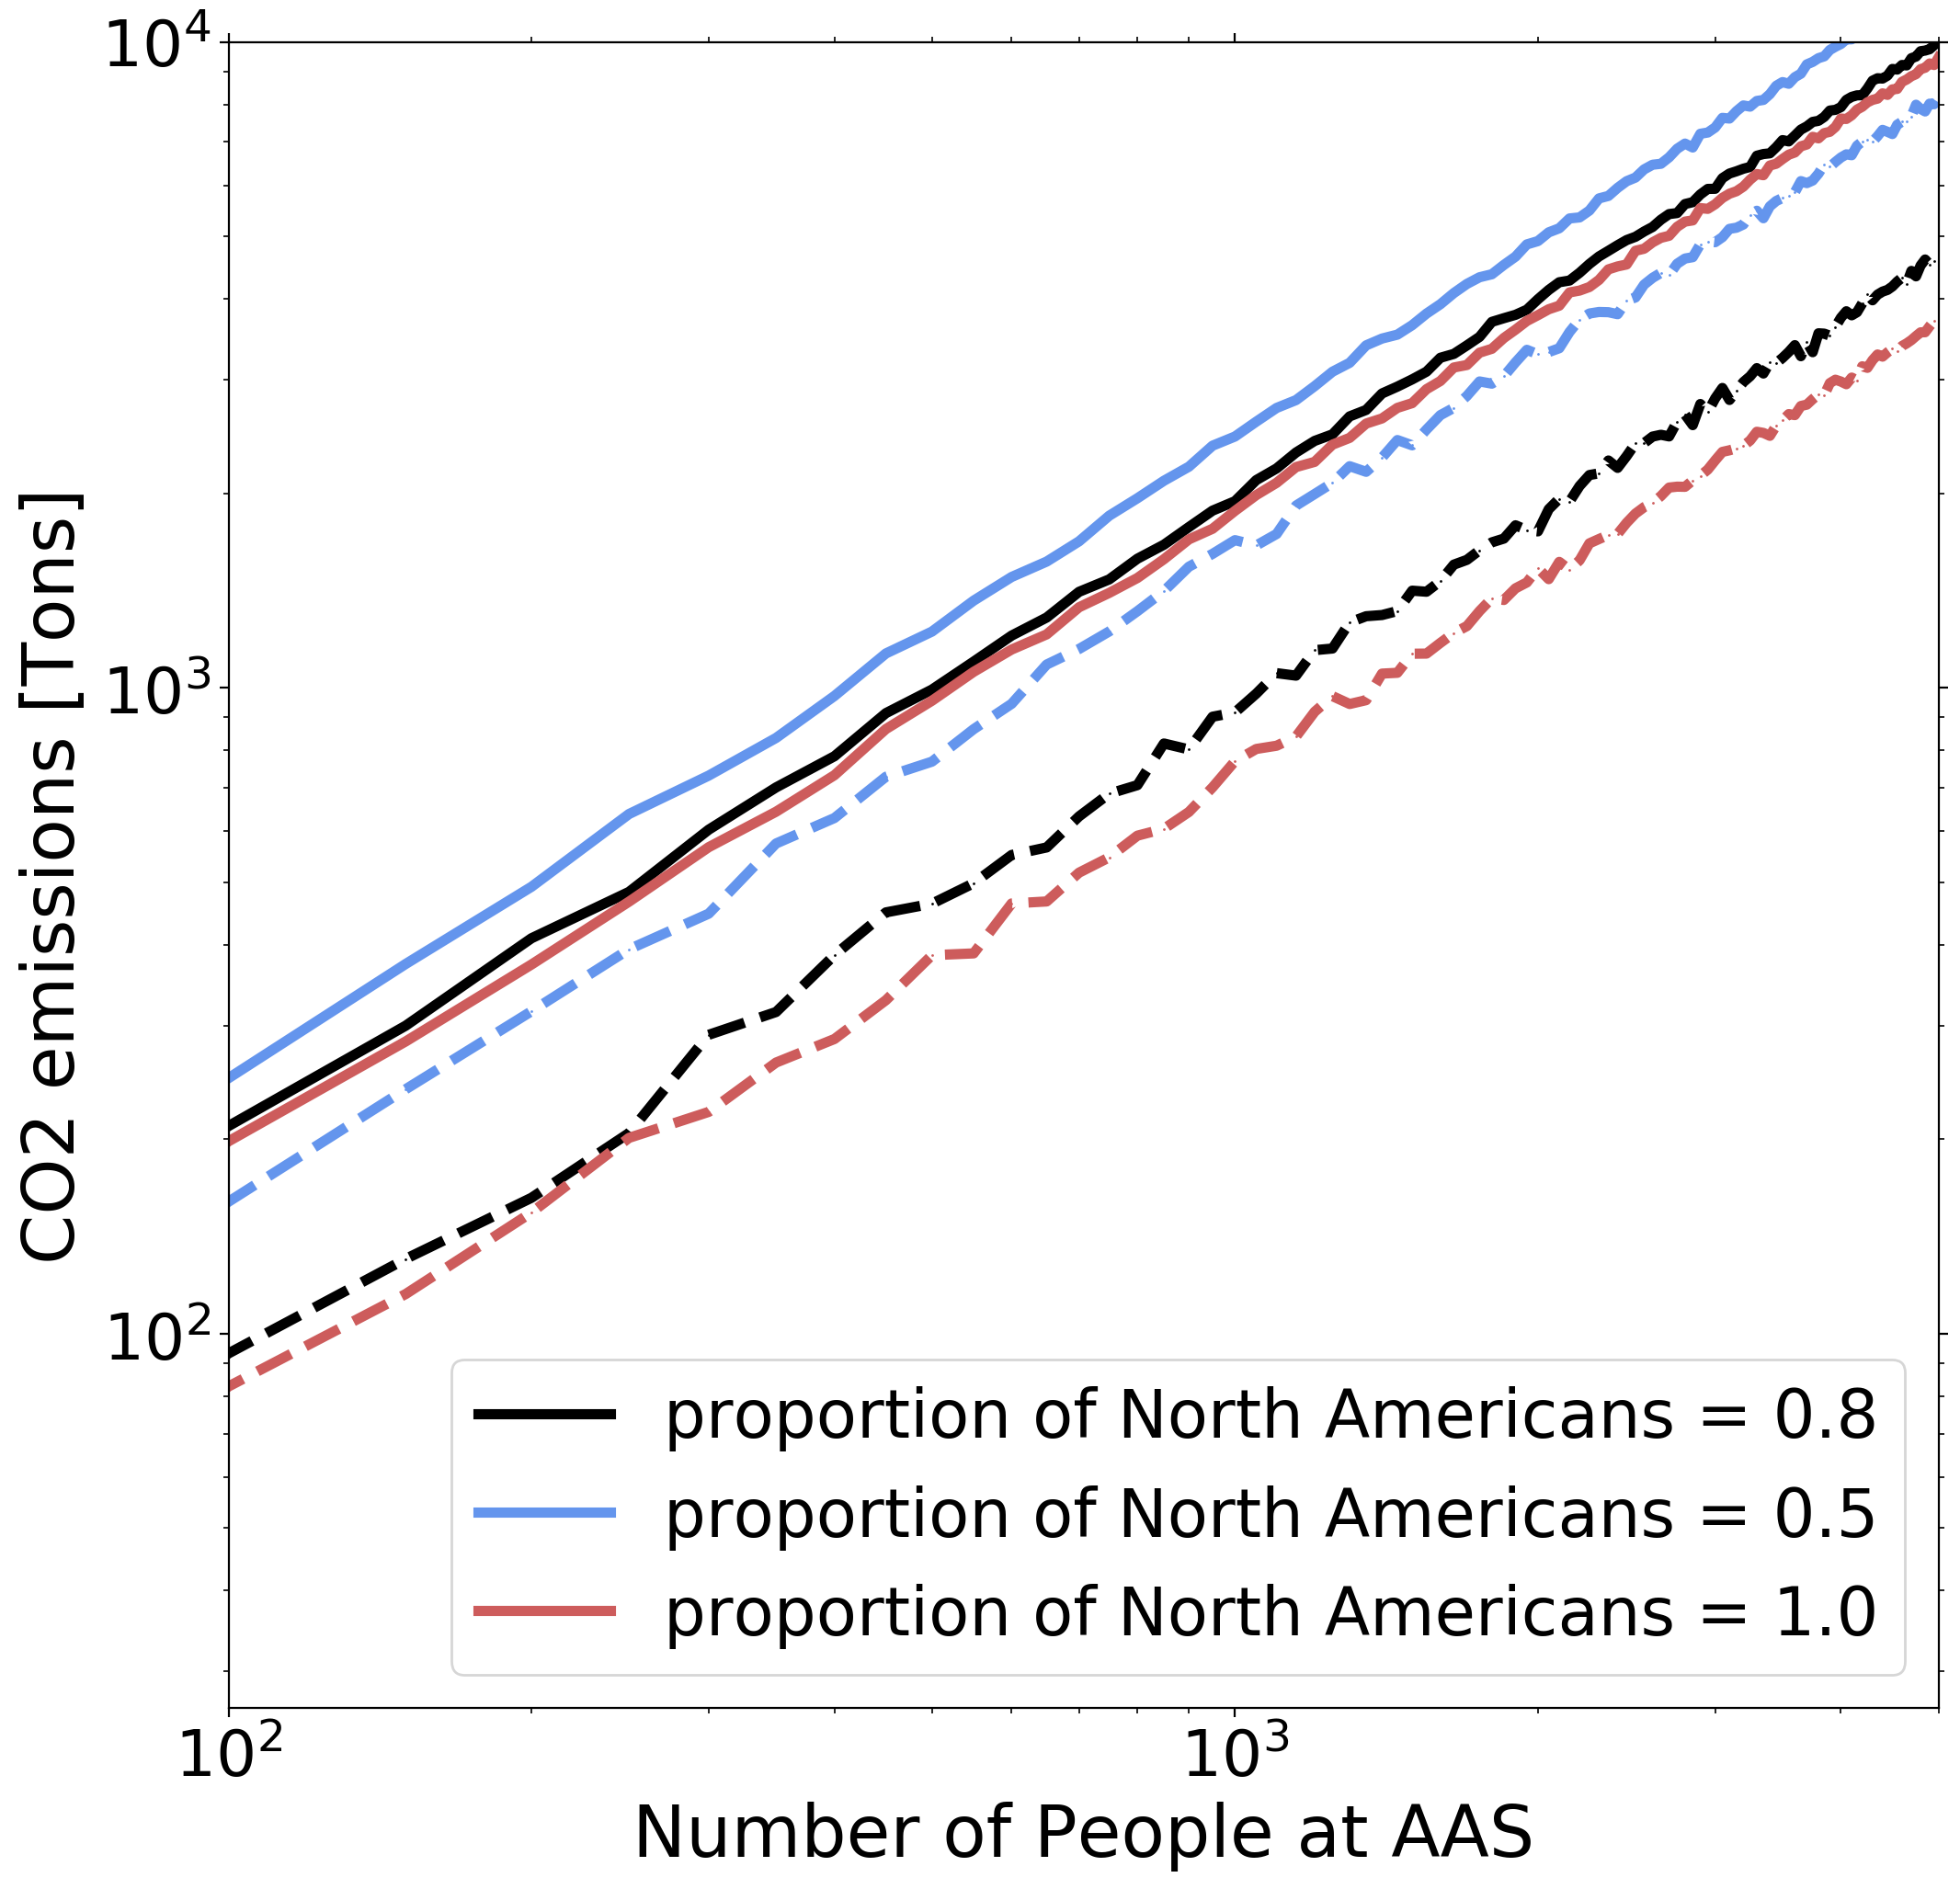

In [96]:
fig = plt.figure(figsize=(12,12))
plt.loglog(people, cc[0.9]/1000, color='k', label='proportion of North Americans = 0.8')
#plt.semilogx(people, cc[0.1]/1000, color='cornflowerblue')
plt.loglog(people, cc[0.5]/1000, color='cornflowerblue', label='proportion of North Americans = 0.5')
plt.loglog(people, cc[1.0]/1000, color='indianred', label='proportion of North Americans = 1.0')
plt.loglog(people, cc2[0.9]/1000, linestyle='--', color='k')
#plt.semilogx(people, cc2[0.1]/1000, color='cornflowerblue', linestyle='--')
plt.loglog(people, cc2[0.5]/1000, color='cornflowerblue', linestyle='--')
plt.loglog(people, cc2[1.0]/1000, color='indianred', linestyle='--')
plt.ylim([0,10000])
plt.xlim([100,5000])
plt.ylabel("CO2 emissions [Tons]")
plt.xlabel("Number of People at AAS")
plt.legend(loc='best')
#plt.axvline(2.5*10**3, linestyle='--', alpha=0.6)

#plt.axhline(5029.9, linestyle='--', alpha=0.6)